In [1]:
import torch
import time
import yaml
import random
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
sys.path.append('/home/yang_liu/python_workspace/3DGS')

import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm import tqdm
from os import makedirs
from scene import Scene
from gaussian_renderer import render
from utils.general_utils import safe_state
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams, get_combined_args
from gaussian_renderer import GaussianModel
from arguments import ModelParams, PipelineParams, OptimizationParams, GroupParams

from scene.cameras import Camera
from utils.general_utils import PILtoTorch

from scene.datasets import GSDataset
from scene import LargeScene
from gaussian_renderer import render_v2

WARNED = False

In [2]:
def parse_cfg(cfg):
    lp = GroupParams()
    op = GroupParams()
    pp = GroupParams()

    for arg in cfg['model_params'].items():
        setattr(lp, arg[0], arg[1])
    
    for arg in cfg['optim_params'].items():
        setattr(op, arg[0], arg[1]) 

    for arg in cfg['pipeline_params'].items():
        setattr(pp, arg[0], arg[1])
    
    return lp, op, pp

def contract_to_unisphere(
        x: torch.Tensor,
        aabb: torch.Tensor,
        ord: float = 2,
        eps: float = 1e-6,
        derivative: bool = False,
    ):
        aabb_min, aabb_max = torch.split(aabb, 3, dim=-1)
        x = (x - aabb_min) / (aabb_max - aabb_min)
        x = x * 2 - 1  # aabb is at [-1, 1]
        mag = torch.linalg.norm(x, ord=ord, dim=-1, keepdim=True)
        mask = mag.squeeze(-1) > 1

        if derivative:
            dev = (2 * mag - 1) / mag**2 + 2 * x**2 * (
                1 / mag**3 - (2 * mag - 1) / mag**4
            )
            dev[~mask] = 1.0
            dev = torch.clamp(dev, min=eps)
            return dev
        else:
            x[mask] = (2 - 1 / mag[mask]) * (x[mask] / mag[mask])
            x = x / 4 + 0.5  # [-inf, inf] is at [0, 1]
            return x

def loadCam(args, id, cam_info, resolution_scale, with_image=True):
    orig_w, orig_h = cam_info.image.size

    if args.resolution in [1, 2, 4, 8]:
        resolution = round(orig_w/(resolution_scale * args.resolution)), round(orig_h/(resolution_scale * args.resolution))
    else:  # should be a type that converts to float
        if args.resolution == -1:
            if orig_w > 1600:
                global WARNED
                if not WARNED:
                    print("[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.\n "
                        "If this is not desired, please explicitly specify '--resolution/-r' as 1")
                    WARNED = True
                global_down = orig_w / 1600
            else:
                global_down = 1
        else:
            global_down = orig_w / args.resolution

        scale = float(global_down) * float(resolution_scale)
        resolution = (int(orig_w / scale), int(orig_h / scale))

    loaded_mask = None
    resized_image_rgb = torch.zeros((3, resolution[1], resolution[0]), dtype=torch.float32)
    gt_image = torch.zeros((3, resolution[1], resolution[0]), dtype=torch.float32)
    if with_image:
        resized_image_rgb = PILtoTorch(cam_info.image, resolution)
        gt_image = resized_image_rgb[:3, ...]

        if resized_image_rgb.shape[1] == 4:
            loaded_mask = resized_image_rgb[3:4, ...]

    return Camera(colmap_id=cam_info.uid, R=cam_info.R, T=cam_info.T, 
                  FoVx=cam_info.FovX, FoVy=cam_info.FovY, 
                  image=gt_image, gt_alpha_mask=loaded_mask,
                  image_name=cam_info.image_name, uid=id, data_device=args.data_device)

In [38]:
config = '../config/block_residence_all_lr_c20_loss_8_r4.yaml'
iteration = 30_000

with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', config)
config_name = os.path.splitext(os.path.basename(config))[0]
lp.source_path = os.path.join("../", lp.source_path)
lp.model_path = os.path.join("../output/", config_name)
lp.pretrain_path = os.path.join("../", lp.pretrain_path)

with torch.no_grad():
    gaussians = GaussianModel(lp.sh_degree)
    scene = LargeScene(lp, gaussians, load_iteration=iteration, shuffle=False)
    gs_dataset = GSDataset(scene.getTrainCameras(), scene, lp, pp)
    print(f'Loaded {gaussians.get_xyz.shape[0]} Points\n')

Loading trained model at iteration 30000
Reading camera 2561/2561
Loaded 10812708 Points



In [41]:
xy_range = lp.aabb
block_dim = lp.block_dim
print(f'xy_range: {xy_range}')
print(f'block_dim: {block_dim}')

with torch.no_grad():
    xyz_org = gaussians.get_xyz
    if len(xy_range) == 4:
        aabb = [xy_range[0], xy_range[1], xyz_org[:, -1].min(), 
                xy_range[2], xy_range[3], xyz_org[:, -1].max()]
    elif len(xy_range) == 6:
        aabb = xy_range
    else:
        assert False, "Unknown aabb format!"
    aabb = torch.tensor(aabb, dtype=torch.float32, device=xyz_org.device)
    xyz = contract_to_unisphere(xyz_org, aabb, ord=torch.inf)

xy_range: [-25, -200, -270, 175, 200, 60]
block_dim: [4, 1, 5]


render time: 0.01598525047302246s
Idx 1690, Image 001703.JPG, Rendered 10812708 points


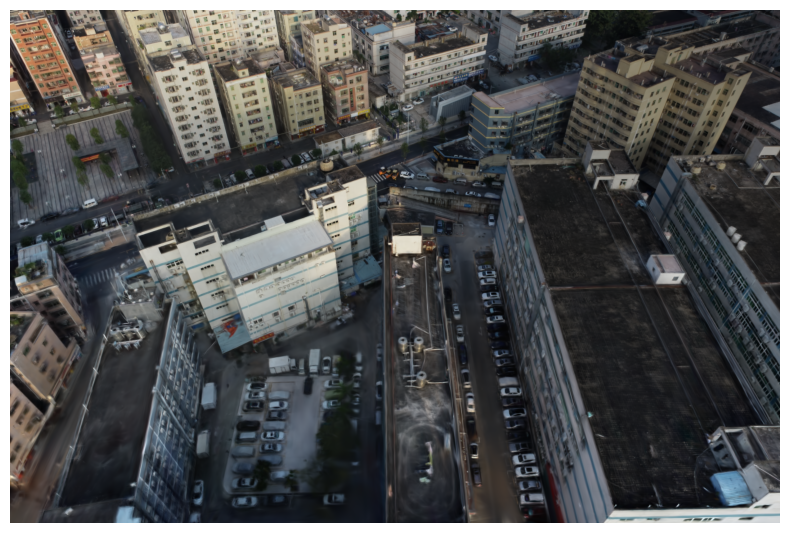

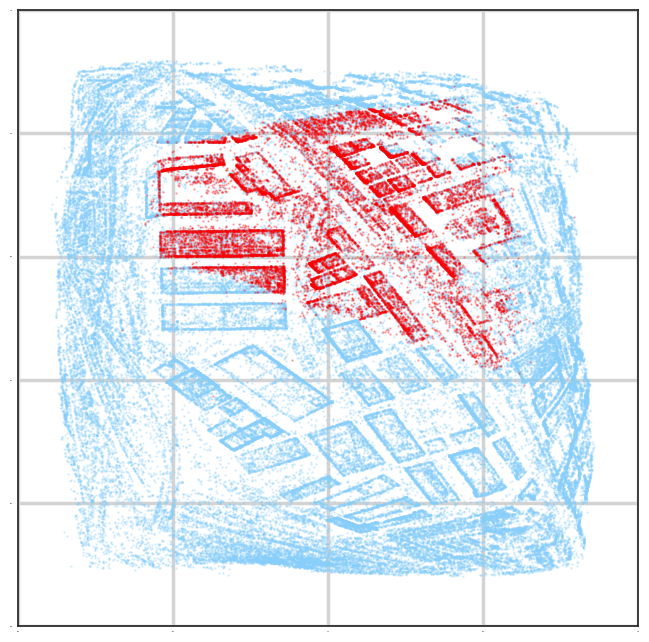

In [43]:
with torch.no_grad():
    # range free for block 9
    # interplay: 1517, 1114, 1538, 884, 849, 1535, 1532, 1264, 106, 99, 55
    # low quality: 1148, 916, 1560, 907

    # range free for block all
    # interplay: 
    # low quality: 101
    idx = random.randint(0, len(gs_dataset)-1)
    # idx = 2908

    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

    cam_info, gt_image = gs_dataset[idx]
    image_name = os.path.split(gs_dataset.cameras[idx].image_path)[1]
    start = time.time()
    render_pkg = render_v2(cam_info, gaussians, pp, background)
    end = time.time()
    print("render time: {}s".format(end-start))
    image = render_pkg["render"]

    image = image.cpu().numpy().transpose(1,2,0)

    # show render results
    plt.style.use('seaborn-white')
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    # plt.title(f"Idx {idx}, Image {image_name}, Rendered {render_pkg['radii'].shape[0]} points")
    print(f"Idx {idx}, Image {image_name}, Rendered {render_pkg['radii'].shape[0]} points")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # show visible points
    font_size = 1
    pts_interval = 100
    plt.figure(figsize=(8, 8))
    visibility_filter = render_pkg["visibility_filter"].cpu().numpy()
    plt.scatter(xyz[::pts_interval, 0].detach().cpu(), xyz[::pts_interval, 2].detach().cpu(), s=0.5, c='lightskyblue', label='overall', alpha=0.3)
    plt.scatter(xyz[visibility_filter][::pts_interval, 0].detach().cpu(), xyz[visibility_filter][::pts_interval, 2].detach().cpu(), s=0.5, c='r', label='visible', alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xticks(np.linspace(0,1,block_dim[0]+1,endpoint=True), fontsize=font_size, color='k')
    plt.yticks(np.linspace(0,1,block_dim[2]+1,endpoint=True), fontsize=font_size, color='k')
    plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    plt.grid(True, color='lightgrey', linewidth=2.5)
    plt.show()